<a href="https://colab.research.google.com/github/OscarOvanger/GeoDecepticon/blob/main/training_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is where the training goes down

 We start of by installing the requirements

In [4]:
!pip install numpy
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install wandb

In [5]:
!git clone https://github.com/OscarOvanger/GeoDecepticon.git

Cloning into 'GeoDecepticon'...
remote: Enumerating objects: 19961, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 19961 (delta 176), reused 79 (delta 79), pack-reused 19702 (from 2)
Receiving objects: 100% (19961/19961), 106.22 MiB | 9.24 MiB/s, done.
Resolving deltas: 100% (399/399), done.
Updating files: 100% (81/81), done.


In [6]:
import os
os.chdir('/content/GeoDecepticon')

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import wandb
import os
import matplotlib.pyplot as plt

from ContinuousViT import ContinuousVisionTransformer
from preprocess import BinaryImageDataset, collate_fn, create_masking_info, extract_patches
from sampler import generate_conditional_images, visualize_conditional_samples

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Conditional pixel indices and values for evaluation
condition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,2000,3312,2953,289,2373,2720,872,2713,1206,1341,3541,2226,3423,1904,2882,2540,1497,2524,264,1441])
condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,1,0,1,0,1,1,0,1])

def train_model():
    """Simple training function for the Continuous Vision Transformer."""
    # Load data
    try:
        arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
        training_data = arr[:9000]
        test_data = arr[9000:]
        training_data = training_data.reshape(-1, 64, 64)
        test_data = test_data.reshape(-1, 64, 64)
        print(f"Training data shape: {training_data.shape}")
        print(f"Test data shape: {test_data.shape}")
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    # Create datasets and dataloaders
    train_dataset = BinaryImageDataset(training_data)
    test_dataset = BinaryImageDataset(test_data)

    batch_size = 64
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )

    # Model parameters
    model_params = {
        'embed_dim': 192,
        'num_heads': 12,
        'feedforward_dim': 768,
        'num_layers': 6,
        'max_patches': 256,
        'dropout': 0.1
    }

    # Initialize device, model, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ContinuousVisionTransformer(**model_params).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Initialize wandb
    wandb.init(
        project="vision-transformer-simplified",
        config={
            **model_params,
            'batch_size': batch_size,
            'learning_rate': 1e-4,
            'num_epochs': 1000,
        },
    )

    # Create directory for checkpoints
    os.makedirs("checkpoints", exist_ok=True)

    # Training variables
    num_epochs = 1000
    best_loss = float('inf')

    # For visualization
    test_batch = next(iter(test_dataloader)).to(device)
    test_image_idx = 0  # Use first image from test batch for visualization

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        # Calculate mask count - simple linear increase
        # Start with 4 masks, end with 252 masks (98.4% of patches)
        num_masks = min(4 + int((252 - 4) * epoch / num_epochs), 252)

        # Fixed partial mask ratio
        partial_mask_ratio = 0.3

        # Training step
        for batch_idx, patches in enumerate(train_dataloader):
            # Move to device
            patches = patches.to(device)

            # Apply masking
            masking_info = create_masking_info(
                patches,
                num_masks=num_masks,
                partial_mask_ratio=partial_mask_ratio
            )

            # Forward pass
            outputs = model(
                patches,
                mask_indices=masking_info['full_mask'],
                partial_mask_indices=masking_info['partial_mask'],
                partial_mask_values=masking_info['partial_values']
            )

            # Calculate loss
            loss = model.get_loss(
                outputs,
                patches,
                mask_indices=masking_info['full_mask'],
                partial_mask_indices=masking_info['partial_mask'],
                partial_mask_values=masking_info['partial_values']
            )

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Calculate average epoch loss
        avg_epoch_loss = epoch_loss / len(train_dataloader)

        # Create visualizations
        if epoch % 20 == 0 or epoch == num_epochs - 1:
            model.eval()

            # Apply masking to test image
            test_masking_info = create_masking_info(
                test_batch,
                num_masks=num_masks,
                partial_mask_ratio=partial_mask_ratio
            )

            # Forward pass on test image
            with torch.no_grad():
                test_outputs = model(
                    test_batch,
                    mask_indices=test_masking_info['full_mask'],
                    partial_mask_indices=test_masking_info['partial_mask'],
                    partial_mask_values=test_masking_info['partial_values']
                )

            # Get original, masked, and reconstructed images
            original_image = model.reconstruct_image(test_batch[test_image_idx])

            # Create masked visualization
            masked_patches = test_batch[test_image_idx].clone()
            # For fully masked patches, set to 0.5 (gray)
            masked_patches[test_masking_info['full_mask'][test_image_idx]] = 0.5
            # For partially masked patches, use partial values
            partial_indices = torch.where(test_masking_info['partial_mask'][test_image_idx])[0]
            for i, idx in enumerate(partial_indices):
                if i < test_masking_info['partial_values'].size(1):
                    masked_patches[idx] = test_masking_info['partial_values'][test_image_idx, i]

            masked_image = model.reconstruct_image(masked_patches)
            reconstructed_image = model.reconstruct_image(test_outputs['binary_prediction'][test_image_idx])

            # Log to wandb
            wandb.log({
                "original_image": wandb.Image(original_image.cpu().numpy()),
                "masked_image": wandb.Image(masked_image.cpu().numpy(), caption=f"Masked ({num_masks} masks)"),
                "reconstructed_image": wandb.Image(reconstructed_image.cpu().numpy()),
            })

        # Log metrics
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_epoch_loss:.4f} - Masks: {num_masks}/256 ({num_masks/256*100:.1f}%)")
        wandb.log({
            "epoch": epoch,
            "epoch_loss": avg_epoch_loss,
            "num_masks": num_masks,
            "masking_percentage": (num_masks / 256) * 100
        })

        # Save best model
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            torch.save(model.state_dict(), "checkpoints/best_model.pth")
            print(f"New best model saved with loss: {best_loss:.4f}")
            wandb.log({"best_loss": best_loss})

        # Generate conditional images every 200 epochs
        if (epoch + 1) % 200 == 0 or epoch == num_epochs - 1:
            try:
                print(f"Generating conditional images at epoch {epoch+1}...")
                images, log_probs = generate_conditional_images(
                    model,
                    condition_indices,
                    condition_values,
                    num_samples=3,
                    device=device
                )

                # Create visualization
                fig = visualize_conditional_samples(
                    images,
                    log_probs,
                    condition_indices,
                    condition_values
                )

                # Log to wandb
                wandb.log({f"conditional_samples_epoch_{epoch+1}": wandb.Image(fig)})
                plt.close(fig)

                print(f"Conditional samples generated with log probs: {log_probs}")
            except Exception as e:
                print(f"Error generating conditional samples: {e}")

        # Simple checkpoint every 500 epochs
        if (epoch + 1) % 500 == 0:
            torch.save(model.state_dict(), f"checkpoints/model_epoch_{epoch+1}.pth")

    # Save final model
    torch.save(model.state_dict(), "checkpoints/final_model.pth")
    print("Training complete!")
    wandb.finish()

if __name__ == "__main__":
    train_model()

Training data shape: (9000, 64, 64)
Test data shape: (1000, 64, 64)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: oscar-ovanger (oscars) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch [1/1000] - Loss: 0.9270 - Masks: 6/256 - Partial: 0.30 - LR: 0.000020
New best model saved with loss: 0.9270
Generating conditional samples...
Conditional samples generated and logged
Epoch [2/1000] - Loss: 0.7769 - Masks: 6/256 - Partial: 0.30 - LR: 0.000040
New best model saved with loss: 0.7769
Training complete!
Generating final conditional samples...


KeyboardInterrupt: 

# Below is old stuff


In [4]:
from dataloader import BinaryImageDataset, preprocess_image
from transformer import VisionTransformer
from PointSSIM_Loss import PointSSIMLoss
import torch
import torch.optim as optim
import torch.nn as nn
import wandb
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sample import reconstruct_image_from_patches
import matplotlib.colors as mcolors
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import colors
import os
from torch.optim.lr_scheduler import StepLR

training data shape:  (9000, 4096)
test data shape:  (1000, 4096)


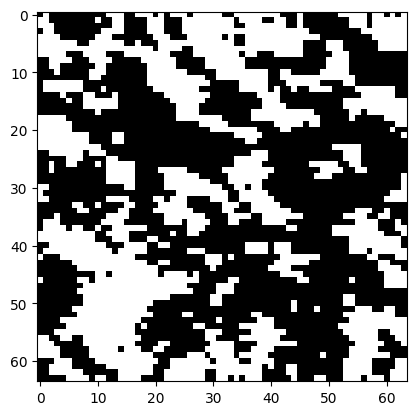

In [5]:
arr = np.load(f"Data/Markov_field/training_data.npz")["arr_0"]

training_data = arr[:9000]
test_data = arr[9000:]
print("training data shape: ", training_data.shape)
print("test data shape: ", test_data.shape)

plt.imshow(training_data[0].reshape(64,64),cmap="gray")
plt.show()

In [12]:
unique_patches, patch_to_idx, idx_to_patch = extract_unique_patches(torch.tensor(training_data.reshape(-1,64,64)))

Analyzing 9000 images to find unique 4x4 patches...
Processed 1000 images, found 14039 unique patches so far
Processed 2000 images, found 18620 unique patches so far
Processed 3000 images, found 21497 unique patches so far
Processed 4000 images, found 23765 unique patches so far
Processed 5000 images, found 25580 unique patches so far
Processed 6000 images, found 27132 unique patches so far
Processed 7000 images, found 28402 unique patches so far
Processed 8000 images, found 29533 unique patches so far
Found 30572 unique 4x4 patches in the training data
Top 5 most common patches and their frequencies:
Patch 0: count=282120, pattern=(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
Patch 1: count=282062, pattern=(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
Patch 2: count=27956, pattern=(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0)
Patch 3: count=27705, pattern=(0.0, 0.0, 0.0, 0.0, 0.0, 

In [9]:
# Create the embedding matrix for all 2x2 binary combinations + 1 mask token
embedding_matrix = torch.zeros((81, 4))  # Shape: (num_tokens, embed_dim)

# Generate all possible 2x2 binary patches
patches = torch.tensor([
    [a, b, c, d]
    for a in range(3)
    for b in range(3)
    for c in range(3)
    for d in range(3)
])  # Shape: (16, 4) for 16 combinations of 2x2 patches
free_indices = torch.zeros(2**4)
masked_indices = torch.zeros(3**4-2**4)
free_idx_counter = 0
masked_idx_counter = 0
# Assign each patch's values as its embedding
for i, patch in enumerate(patches):
    new_patch = torch.where(patch == 2.0,0.5,patch)
    if torch.all(new_patch == patch):
        free_indices[free_idx_counter] = int(i)
        free_idx_counter += 1
    else:
        masked_indices[masked_idx_counter] = int(i)
        masked_idx_counter += 1
    embedding_matrix[i] = new_patch


print("Embedding Matrix:\n", embedding_matrix)
print("free indices:\n", free_indices)
print("masked indices:\n", masked_indices)

Embedding Matrix:
 tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.5000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.5000],
        [0.0000, 0.0000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.5000, 1.0000],
        [0.0000, 0.0000, 0.5000, 0.5000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.0000, 0.5000],
        [0.0000, 1.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 1.0000],
        [0.0000, 1.0000, 1.0000, 0.5000],
        [0.0000, 1.0000, 0.5000, 0.0000],
        [0.0000, 1.0000, 0.5000, 1.0000],
        [0.0000, 1.0000, 0.5000, 0.5000],
        [0.0000, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000, 1.0000],
        [0.0000, 0.5000, 0.0000, 0.5000],
        [0.0000, 0.5000, 1.0000, 0.0000],
        [0.0000, 0.5000, 1.0000, 1.0000],
        [0.0000

In [7]:
# Load the model parameters
# Convert to tensors, should be type Long
training_images = torch.tensor(training_data, dtype=torch.long)
test_images = torch.tensor(test_data, dtype=torch.long)

# Parameters
batch_size = 60
embed_dim = 4
num_heads = 2
feedforward_dim = 128
num_layers = 2
num_tokens = 81  # 3^4 tokens
max_patches = 32 * 32
dropout = 0.2
learning_rate = 3e-4
num_epochs = 3000
hidden_dim = 32

# Dataset and DataLoader
dataset = BinaryImageDataset(training_images)  # Assumes training_images is already loaded
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = VisionTransformer(embed_dim, num_heads, feedforward_dim, num_layers, num_tokens, max_patches, dropout, hidden_dim).to(device)

# Define optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def prob_log_scheduler(x,max_patches,min_patches,num_epochs,rand_size):
    value = max_patches*np.log((((np.exp(1)-1)*x)/num_epochs) + 1) + min_patches
    i = 0
    for val in value:
      rand_comp = np.random.randint(-rand_size,rand_size)*(val/num_epochs)
      #print("random value:", rand_comp)
      val = int(val + rand_comp)
      if val > max_patches:
          val = max_patches
      elif val < min_patches:
          val = min_patches
      value[i] = val
      i += 1
    return value

def convergence_scheduler(num_mask,prev_loss,curr_loss,eps):
  #Check if the prev_loss list is larger than one
  if len(prev_loss) <  5:
    return num_mask
  if np.abs(np.sum(curr_loss-np.array(prev_loss[-5:]))) < eps:
    return num_mask + 1
  else:
    return num_mask

In [ ]:
import wandb
wandb.login()

# Initialize wandb project
wandb.init(
    project="vision-transformer",
    config={
        "batch_size": batch_size,
        "embed_dim": embed_dim,
        "num_heads": num_heads,
        "feedforward_dim": feedforward_dim,
        "num_layers": num_layers,
        "num_tokens": num_tokens,
        "max_patches": max_patches,
        "dropout": dropout,
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "hidden_dim": hidden_dim,
    },
)

reconstructed_images = []
original_images = []
prev_loss = []
# Directory to save checkpoints
os.makedirs("checkpoints", exist_ok=True)
#maskings = y

# Set num mask
current_num_mask = 1
eps = 0.005
#curr_loss = 1000
# Training Loop
# NBNBNB!!! HERE I DO RANDOM MASKING RATES
model.train()
for epoch in range(num_epochs):
    #total_loss = 0
    #current_num_mask = convergence_scheduler(current_num_mask,prev_loss,curr_loss,eps)
    #prev_loss.append(curr_loss)
    current_num_mask = torch.randint(1,max_patches,(1,)).item()
    for batch_idx, images in enumerate(dataloader):
        # Preprocess images
        patch_indices = torch.stack([preprocess_image(img,embedding_matrix) for img in images]).long() #(batch_size,num_patches)
        masked_patches = patch_indices.clone() #(batch_size,num_patches)

        # Generate random indices for masking
        random_indices = torch.rand(batch_size, max_patches).argsort(dim=1)[:, :current_num_mask]
        # Create the mask tensor
        mask = torch.zeros((batch_size, max_patches), dtype=torch.bool)
        mask.scatter_(1, random_indices, True)

        #Mask
        maskings = np.random.choice(masked_indices,current_num_mask,replace=True)
        maskings = (torch.tensor([maskings for _ in range(batch_size)]).reshape(batch_size*current_num_mask)).long()
        # For the mask indices
        masked_patches[mask] = maskings  # Replace masked patches with the mask token

        # Define weighted CrossEntropyLoss
        criterion = nn.CrossEntropyLoss()

        # Move to device
        masked_patches, patch_indices, mask = (
            masked_patches.to(device),
            patch_indices.to(device),
            mask.to(device),
        )

        # Forward pass
        logits = model(masked_patches) # (batch_size,max_patches,num_tokens - 1)
        # Isolate the masked patches
        # Get the indices of True values
        indices = mask.nonzero(as_tuple=True)  # Returns indices where mask is True
        # Extract logits at masked positions while maintaining row-wise structure
        masked_logits = logits[indices[0], indices[1]]  # Extracts all True-index logits
        masked_patch_indices = patch_indices[indices[0], indices[1]]  # Extracts all True-index patch indices
        # Reshape to [batch_size, num_masked_patches, num_classes]
        masked_logits = masked_logits.view(batch_size, current_num_mask, -1)  # (batch_size, current_num_mask, num_tokens-1)
        masked_patch_indices = masked_patch_indices.view(batch_size, current_num_mask) #(batch_size, current_num_mask)


        #Compute logits
        loss = criterion(masked_logits.view(-1, num_tokens-1), masked_patch_indices.view(-1))
        total_loss += loss.item()
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # Log batch metrics
        wandb.log({"batch loss": loss.item()})

        # Visualization for the first batch in the epoch
        if batch_idx == 0:
          with torch.no_grad():
              # Initialize predicted_indices with original patch indices
              predicted_indices = patch_indices.cpu()[0].clone()

              # Predict only the masked indices
              masked_predictions = torch.argmax(masked_logits, dim=-1).cpu()  # Shape: [batch_size, current_num_mask]
              predicted_indices[mask[0]] = masked_predictions[0]  # Update only masked indices

              # Reconstruct images
              reconstructed_image = reconstruct_image_from_patches(predicted_indices)
              reconstructed_images.append(reconstructed_image)
              original_images.append(reconstruct_image_from_patches(patch_indices.cpu()[0]))


              # Prepare masked image for visualization
              visualized_masked_patches = masked_patches.cpu()[0].clone()
              visualized_masked_patches[visualized_masked_patches == num_tokens - 1] = -1
              masked_image = reconstruct_image_from_patches(visualized_masked_patches)

              # Log visualizations to wandb
              wandb.log({
                  "Original Image": wandb.Image(
                      reconstruct_image_from_patches(patch_indices.cpu()[0])
                  ),
                  "Masked Image": wandb.Image(masked_image, caption="Masked Image"),
                  "Reconstructed Image": wandb.Image(
                      reconstructed_image, caption="Reconstructed Image"
                  ),
              })

    avg_loss = total_loss / len(dataloader)
    curr_loss = avg_loss
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_loss:.4f}")

    # Log epoch metrics
    wandb.log({"epoch_loss": avg_loss, "masked_patches": current_num_mask})

    # Save checkpoint periodically
    if (epoch + 1) % 100 == 0:
        #checkpoint_path = f"checkpoints/vision_transformer_epoch_{epoch+1}.pth"
        #validation_metrics = validate(checkpoint_path,epoch,current_num_mask,marginal_priors)
        # Create a table to store data
        #table = wandb.Table(columns=["Patch ID", "3x3_freq_test_images", "3x3_freq_reconstructed_images"])

        # Populate the table
        #for i in range(512):
        #    table.add_data(i, validation_metrics[2][i], validation_metrics[3][i])

        # Create a side-by-side bar plot
        #bar_plot = wandb.plot.bar(table, "Patch ID", ["3x3_freq_test_images", "3x3_freq_reconstructed_images"],
        #                          title="3x3 Patch Frequency Comparison")

        #wandb.log({
        #    "validation_loss": validation_metrics[0],
        #    "PointSSIM_loss": 1-torch.mean(validation_metrics[1]),
        #    "Patch Frequency Bar Plot": bar_plot
        #})
        checkpoint_path = f"checkpoints/vision_transformer_epoch_{epoch+1}.pth"
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
            },
            checkpoint_path,
        )
        print(f"Checkpoint saved for epoch {epoch+1}")
        wandb.save(checkpoint_path)

        #Do validation
        model.eval()


# Save the final model
torch.save(model.state_dict(), "vision_transformer_final_balanced.pth")
wandb.save("vision_transformer_final_balanced.pth")
print("Final model saved as 'vision_transformer_final_balanced.pth'.")
wandb.finish()

# Compute prior logits

In [ ]:
all_data = torch.tensor(np.concatenate((training_data,test_data),axis=0), dtype=torch.long)
all_patches = torch.stack([preprocess_image(img) for img in all_data]).long() #(9000,32*32)
# Compute the probability for all patches in the image.
marginal_priors = torch.zeros((all_patches.shape[1],num_tokens-1)) #(32*32,16)
for i in range(all_patches.shape[0]):
  for j in range(all_patches.shape[1]):
    marginal_priors[j,all_patches[i,j]] += 1
marginal_priors = marginal_priors/all_patches.shape[0]

# Test that the PointSSIM works

<ipython-input-11-dc71ce15150d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


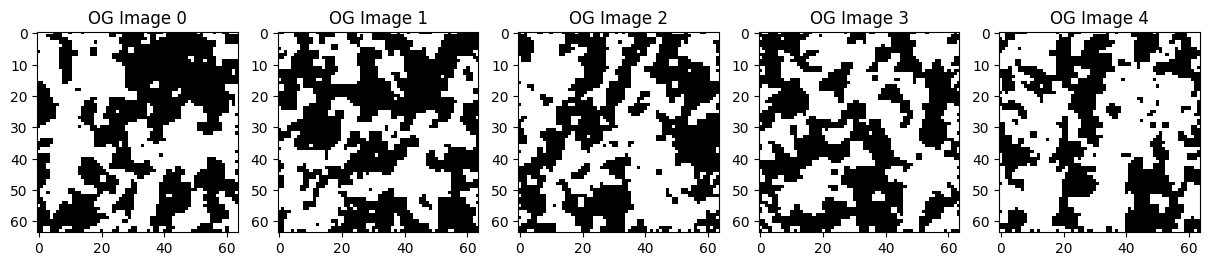

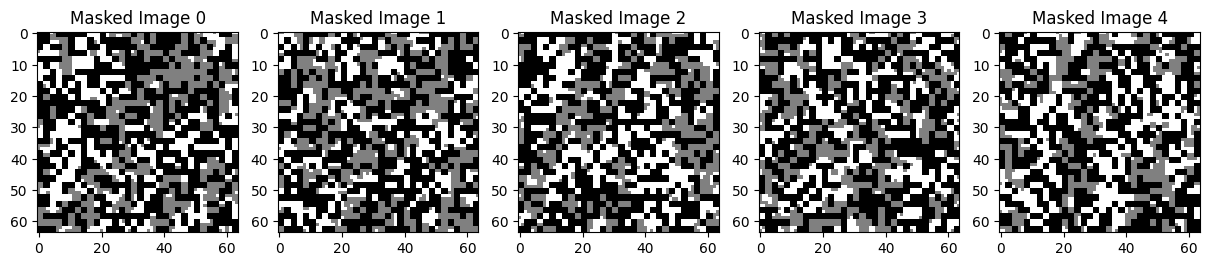

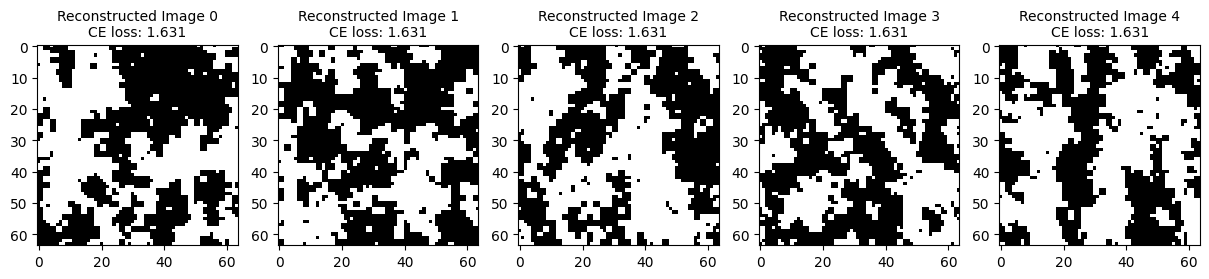

<ipython-input-11-dc71ce15150d>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PointSSIM_scores = PointSSIM_loss(torch.tensor(batch_test,dtype=torch.float),torch.tensor(np.array(reconstructed_images),dtype=torch.float))
/content/GeoDecepticon/PointSSIM_Loss.py:155: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  features1 = torch.tensor(features1, dtype=img_batch1.dtype, device=img_batch1.device)


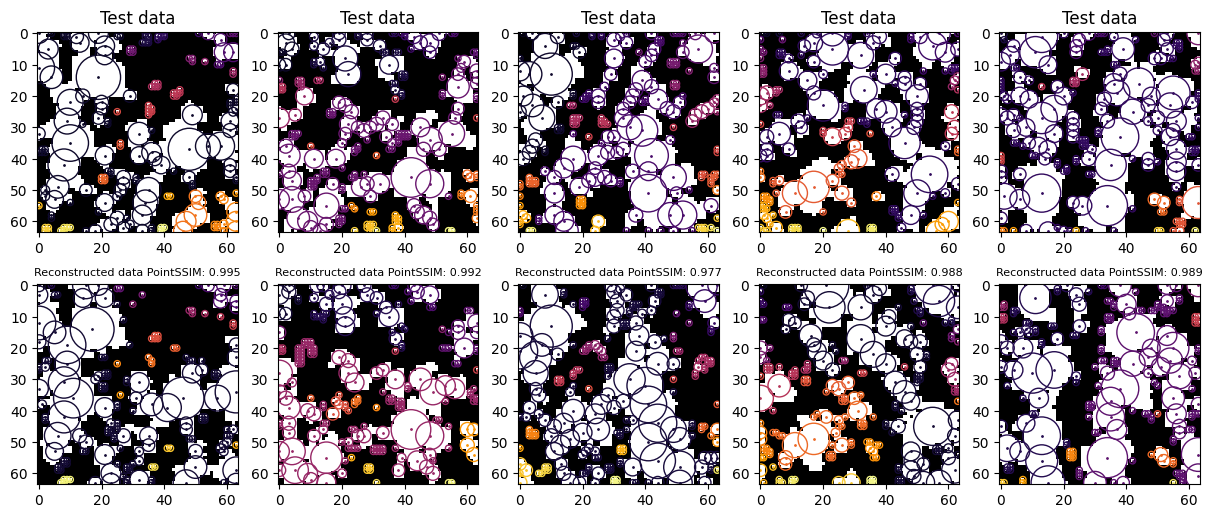

In [ ]:
PointSSIM_loss = PointSSIMLoss()
CE_loss = nn.CrossEntropyLoss()
# Load the latest epoch of the vision transformer
checkpoint_path = "Models/vision_transformer_sample.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
# Take a test image and mask randomly 50% of cells
batch_test = test_images[:5]
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
  ax[i].imshow(batch_test[i],cmap="gray")
  ax[i].set_title("OG Image " + str(i))
plt.show()

batch_test = test_images[:5]
# Preprocess images
patch_indices = torch.stack([preprocess_image(img) for img in batch_test]).long() #(btach_size,max_patches)
masked_patches = patch_indices.clone() #(btach_size,max_patches)

current_num_mask = 512
batch_size = 5
# Generate random indices for masking
random_indices = torch.rand(batch_size, max_patches).argsort(dim=1)[:, :current_num_mask]
# Create the mask tensor
mask = torch.zeros((batch_size, max_patches), dtype=torch.bool)
mask.scatter_(1, random_indices, True)

#Mask
masked_patches[mask] = num_tokens - 1  # Replace masked patches with the mask token

# Prepare masked image for visualization
visualized_masked_patches = masked_patches.cpu().clone()
visualized_masked_patches[visualized_masked_patches == num_tokens - 1] = -1
masked_images = []
for i in range(batch_size):
  masked_images.append(reconstruct_image_from_patches(visualized_masked_patches[i]))

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
  ax[i].imshow(masked_images[i],cmap="gray")
  ax[i].set_title("Masked Image " + str(i))
plt.show()

# Initialize predicted_indices with original patch indices
predicted_indices = patch_indices.cpu().clone()

# Forward pass
logits = model(masked_patches.to(device)) # (batch_size,max_patches,num_tokens - 1)
# Isolate the masked patches
# Get the indices of True values
indices = mask.nonzero(as_tuple=True)  # Returns indices where mask is True
# Extract logits at masked positions while maintaining row-wise structure
masked_logits = logits[indices[0], indices[1]]  # Extracts all True-index logits
masked_logits = masked_logits.view(batch_size, current_num_mask, -1)  # (batch_size, current_num_mask, num_tokens-1)
masked_patch_indices = patch_indices[indices[0], indices[1]]  # Extracts all True-index patch indices
masked_patch_indices = masked_patch_indices.view(batch_size, current_num_mask) #(batch_size, current_num_mask)

#Compute logits
loss = CE_loss(masked_logits.view(-1, num_tokens-1).to(device), masked_patch_indices.view(-1).to(device))

# Predict only the masked indices
masked_predictions = torch.argmax(masked_logits, dim=-1).cpu()  # Shape: [batch_size, current_num_mask]
reconstructed_images = []
for i in range(batch_size):
  predicted_indices[i][mask[i]] = masked_predictions[i]
  reconstructed_images.append(reconstruct_image_from_patches(predicted_indices[i]))

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
  ax[i].imshow(reconstructed_images[i],cmap="gray")
  ax[i].set_title(f"Reconstructed Image {i}\nCE loss: {loss.item():.3f}", fontsize=10)
plt.show()

# Now we do PointSSIM on both OG and Reconstructed images
anchors_test = []
anchors_reconstructed = []
for i in range(batch_size):
  anchors_test.append(PointSSIM_loss.custom_anchors(batch_test[i],batch_test[i].shape[0],True))
  anchors_reconstructed.append(PointSSIM_loss.custom_anchors(reconstructed_images[i],reconstructed_images[i].shape[0],True))

PointSSIM_scores = PointSSIM_loss(torch.tensor(batch_test,dtype=torch.float),torch.tensor(np.array(reconstructed_images),dtype=torch.float))

import seaborn as sns
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    nr_anchor_points_test = np.sum(anchors_test[i][0])
    nr_anchor_points_reconstructed = np.sum(anchors_reconstructed[i][0])
    ax[0,i].imshow(batch_test[i], cmap='gray')
    ax[0,i].set_title('Test data')
    ax[1,i].imshow(reconstructed_images[i], cmap='gray')
    ax[1,i].set_title(f'Reconstructed data PointSSIM: {PointSSIM_scores[i]:.3f}', fontsize=8)
    colors = sns.color_palette('inferno', int(np.max(anchors_test[i][2])) + 1)
    for k in range(int(nr_anchor_points_test)):
        x, y = np.where(anchors_test[i][0])[0][k], np.where(anchors_test[i][0])[1][k]
        r = anchors_test[i][1][x, y]
        ax[0,i].plot(y, x, 'o', markersize=1, color=colors[int(anchors_test[i][2][x, y])])
        circle = plt.Circle((y, x), r, color=colors[int(anchors_test[i][2][x, y])], fill=False)
        ax[0,i].add_artist(circle)
    colors = sns.color_palette('inferno', int(np.max(anchors_reconstructed[i][2])) + 1)
    for k in range(int(nr_anchor_points_reconstructed)):
        x, y = np.where(anchors_reconstructed[i][0])[0][k], np.where(anchors_reconstructed[i][0])[1][k]
        r = anchors_reconstructed[i][1][x, y]
        ax[1,i].plot(y, x, 'o', markersize=1, color=colors[int(anchors_reconstructed[i][2][x, y])])
        circle = plt.Circle((y, x), r, color=colors[int(anchors_reconstructed[i][2][x, y])], fill=False)
        ax[1,i].add_artist(circle)
plt.show()

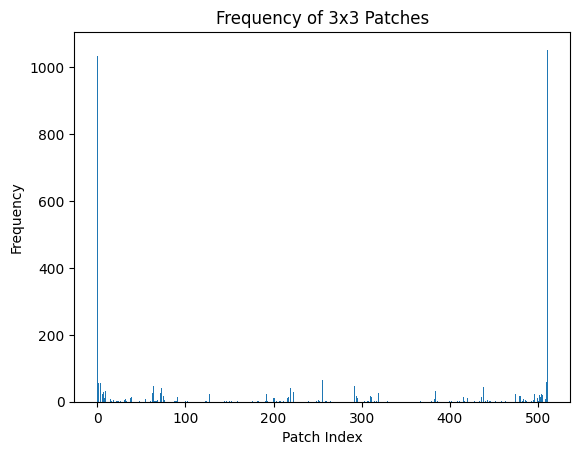

In [ ]:
import numpy as np
from scipy.signal import convolve2d

def count_3x3_patches(binary_image):
    # Ensure binary_image is a NumPy array
    binary_image = np.array(binary_image, dtype=np.uint8)

    # Define convolutional kernel to extract 3x3 patches
    kernel = np.array([[256, 128, 64],  # Top row (highest bits)
                       [32, 16, 8],     # Middle row
                       [4, 2, 1]])      # Bottom row (lowest bits)

    # Apply convolution to compute unique index for each 3x3 patch
    patch_indices = convolve2d(binary_image, kernel, mode='valid')

    # Count occurrences of each patch
    patch_counts = np.bincount(patch_indices.ravel(), minlength=512)

    return patch_counts

# Example: Generate a random 64x64 binary image
binary_image = batch_test[0]

# Get patch frequencies
patch_frequencies = count_3x3_patches(binary_image)

# Display patch frequencies
plt.bar(range(512), patch_frequencies)
plt.xlabel('Patch Index')
plt.ylabel('Frequency')
plt.title('Frequency of 3x3 Patches')
plt.show()

In [ ]:
# Validation part
def validate(model,epoch,num_masked,marginal_priors):
  PointSSIM_loss = PointSSIMLoss()
  #checkpoint_path = f"checkpoints/vision_transformer_epoch_{epoch+1}.pth"
  checkpoint_path = "vision_transformer_sample.pth"
  checkpoint = torch.load(checkpoint_path)
  model.load_state_dict(checkpoint["model_state_dict"])
  model.eval()
  batch_test_idx = np.random.choice(np.arange(test_data.shape[0]), 60)
  batch_test = torch.tensor(test_data[batch_test_idx],dtype=torch.long)

  # Preprocess images
  patch_indices = torch.stack([preprocess_image(img) for img in batch_test]).long() #(btach_size,max_patches)
  masked_patches = patch_indices.clone() #(btach_size,max_patches)

  current_num_mask = num_masked
  batch_size = 60
  # Generate random indices for masking
  random_indices = torch.rand(batch_size, max_patches).argsort(dim=1)[:, :current_num_mask]
  # Create the mask tensor
  mask = torch.zeros((batch_size, max_patches), dtype=torch.bool)
  mask.scatter_(1, random_indices, True)

  #Mask
  masked_patches[mask] = num_tokens - 1  # Replace masked patches with the mask token

  # Prepare masked image for visualization
  visualized_masked_patches = masked_patches.cpu().clone()
  visualized_masked_patches[visualized_masked_patches == num_tokens - 1] = -1
  masked_images = []
  for i in range(batch_size):
    masked_images.append(reconstruct_image_from_patches(visualized_masked_patches[i]))


  # Initialize predicted_indices with original patch indices
  predicted_indices = patch_indices.cpu().clone()

  # Forward pass
  logits = model(masked_patches.to(device)) # (batch_size,max_patches,num_tokens - 1)
  # Isolate the masked patches
  # Get the indices of True values
  indices = mask.nonzero(as_tuple=True)  # Returns indices where mask is True
  # Extract logits at masked positions while maintaining row-wise structure
  masked_logits = logits[indices[0], indices[1]]  # Extracts all True-index logits
  masked_logits = masked_logits.view(batch_size, current_num_mask, -1)  # (batch_size, current_num_mask, num_tokens-1)
  masked_patch_indices = patch_indices[indices[0], indices[1]]  # Extracts all True-index patch indices
  masked_patch_indices = masked_patch_indices.view(batch_size, current_num_mask) #(batch_size, current_num_mask)

  #Compute logits
  loss = CE_loss(masked_logits.view(-1, num_tokens-1).to(device), masked_patch_indices.view(-1).to(device))

  # Predict only the masked indices
  masked_predictions = torch.argmax(masked_logits, dim=-1).cpu()  # Shape: [batch_size, current_num_mask]
  reconstructed_images = []
  for i in range(batch_size):
    predicted_indices[i][mask[i]] = masked_predictions[i]
    reconstructed_images.append(reconstruct_image_from_patches(predicted_indices[i]))

  #Compute the PointSSIM scores
  PointSSIM_scores = PointSSIM_loss(torch.tensor(batch_test,dtype=torch.float),torch.tensor(np.array(reconstructed_images),dtype=torch.float))

  # Compute the 3x3-patches
  three_patches_test = np.mean(np.array([count_3x3_patches(img) for img in batch_test]),axis=0) #(512)
  three_patches_reconstructed = np.mean(np.array([count_3x3_patches(img) for img in reconstructed_images]),axis=0) #(512)
  three_patch_prob_test = three_patches_test/np.sum(three_patches_test)
  three_patch_prob_reconstructed = three_patches_reconstructed/np.sum(three_patches_reconstructed)

  return loss.item(),PointSSIM_scores,three_patch_prob_test,three_patch_prob_reconstructed,marginal_priors


